### Purpose
- sometimes events are required to 

### Imports

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])
    
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from neuropy import plotting
from tqdm.notebook import tqdm
from neuropy.core import Epoch
from neuropy.utils.mathutil import min_max_scaler
from neuropy import plotting
from scipy import stats
import pandas as pd
import subjects
from neuropy.core import Epoch
from neuropy.utils.mathutil import choose_elementwise
from replay_utils import is_good_posterior, is_continuous_posterior
from replay_utils import get_max_length
from neuropy.analyses.decoders import column_shift
from joblib import delayed, Parallel

## NRK sanity checks on replay metrics and stats.

In [4]:
sessions = subjects.pf_sess()

#Sessions = 13


In [35]:
sess = sessions[1]  # RatN Day2
pbe_epochs = Epoch(epochs=None, file=sess.filePrefix.with_suffix(".pbe.replay.npy"))
pbe_mua_epochs = Epoch(epochs=None, file = sess.filePrefix.with_suffix(".pbe.replay.mua.npy"))
pbe_mua_col_epochs = Epoch(epochs=None, file = sess.filePrefix.with_suffix(".pbe.replay.mua.column.npy"))
pbe_mua_nrk_epochs = Epoch(epochs=None, file = sess.filePrefix.with_suffix(".pbe.replay.mua.NRK.npy"))
pbe_mua_nrk2_epochs = Epoch(epochs=None, file = sess.filePrefix.with_suffix(".pbe.replay.mua.NRK2.npy"))

Text(0.5, 1.0, 'NRK2 vs NRK')

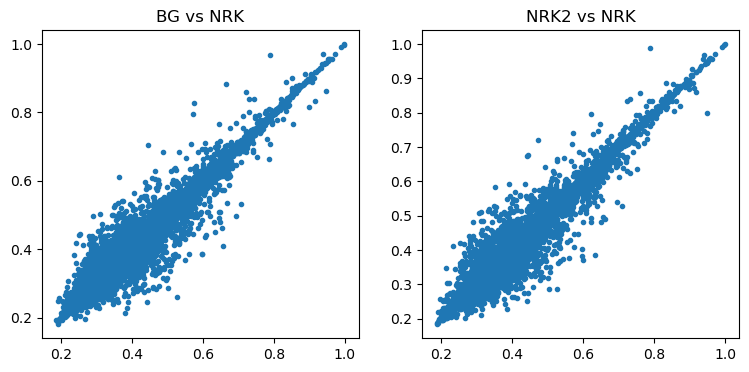

In [36]:
# Double check - is inconsistency between BG and NRK runs of radon transform due to NRK mistake or due to the non-deterministic way the radon
# transform is calculated, e.g. by plotting a lot of random lines and finding the best fit, which can get noisy for poorer replays?
#
# Answer: the noise is just inherent in the radon transform - BG vs. NRK looks the same as two identical runs of the code in 
# 'sd_replay_wcorr.py' script by NRK.

_, ax = plt.subplots(1, 2, figsize=(9, 4))
metric = 'up_radon'
ax[0].plot(pbe_mua_nrk_epochs.to_dataframe()[metric].values, 
        pbe_mua_epochs.to_dataframe()[metric].values, '.')
ax[0].set_title('BG vs NRK')
ax[1].plot(pbe_mua_nrk_epochs.to_dataframe()[metric].values, 
        pbe_mua_nrk2_epochs.to_dataframe()[metric].values, '.')
ax[1].set_title('NRK2 vs NRK')

### Save replay pbes based on certain criteria

In [41]:
sessions = subjects.pf_sess()

jump_thresh = 20
save_append = "" if jump_thresh == 40 else f".jumpthresh{jump_thresh}"

for s, sess in enumerate(sessions):
    print(sess.name)
    replay_measures = sess.replay_pbe_mua
    metadata = sess.replay_pbe_mua.metadata
    shuffle_metadata = sess.replay_pbe_mua_column.metadata

    replay_measures_df = replay_measures.to_dataframe()
    replay_measures_df.loc[:, "down_wcorr"] *= -1
    up_posteriors = metadata["up_posterior"]
    down_posteriors = metadata["down_posterior"]
    up_shuffle_measures = shuffle_metadata["up_shuffle_measures"]
    down_shuffle_measures = shuffle_metadata["down_shuffle_measures"]

    starts = replay_measures_df.start.values
    stops = replay_measures_df.stop.values

    measure_names = ["wcorr", "jd", "radon", "vel", "intercept"]
    up_replay_measures = (
        replay_measures_df.loc[:, ["up_" + _ for _ in measure_names]].to_numpy().T
    )

    down_replay_measures = (
        replay_measures_df.loc[:, ["down_" + _ for _ in measure_names]].to_numpy().T
    )

    best_bool = np.abs(up_replay_measures[1]) <= np.abs(down_replay_measures[1])
    wcorr, jd, radon, vel, intercept = choose_elementwise(
        up_replay_measures, down_replay_measures, best_bool
    )
    shuffle_measures = choose_elementwise(
        up_shuffle_measures, down_shuffle_measures, best_bool
    )
    posteriors = choose_elementwise(up_posteriors, down_posteriors, best_bool)

    # ---- calculating percentiles --------
    perc_shuffle = []
    for shfl, score in zip(
        [shuffle_measures[:, 0, :], shuffle_measures[:, 1, :]], [wcorr, jd]
    ):
        perc_shuffle.append(
            np.array(
                [
                    stats.percentileofscore(shfl[:, i], score[i], kind="strict")
                    for i in range(len(score))
                ]
            )
        )

    epoch_df = pd.DataFrame(
        dict(
            start=starts,
            stop=stops,
            wcorr=wcorr,
            jd=jd,
            radon=radon,
            vel=vel,
            intercept=intercept,
            wcorr_perc=perc_shuffle[0],
            jd_perc=perc_shuffle[1],
            posterior=posteriors,
        )
    )

    # --- replay Filters ----------
    pbe_filter = sess.pbe_filters.to_dataframe()
    good_pbe = (pbe_filter.is_rpl & pbe_filter.is_5units & pbe_filter.is_rest).values

    # good_posteriors_bool = is_good_posterior(posteriors)
    cont_posteriors_bool = is_continuous_posterior(posteriors, jump_thresh=jump_thresh)
    chosen_bool = good_pbe & cont_posteriors_bool
    epoch_df = epoch_df[chosen_bool].reset_index(drop=True)

    # ---- compare with shuffle ------

    cont_posteriors = epoch_df["posterior"].to_list()
    max_lengths = np.array([get_max_length(_) for _ in cont_posteriors])
    stack_cont_posteriors = np.hstack(cont_posteriors)
    cum_nbins = np.cumsum([_.shape[1] for _ in cont_posteriors])[:-1]

    sh_max_lengths = np.zeros((1000, len(max_lengths)))
    for i in tqdm(range(1000)):
        rand_posteriors = np.hsplit(column_shift(stack_cont_posteriors), cum_nbins)

        results = Parallel(n_jobs=6)(
            delayed(get_max_length)(p) for p in rand_posteriors
        )
        sh_max_lengths[i, :] = results

    maxlen_perc_shuffle = [
        stats.percentileofscore(sh_max_lengths[:, i], max_lengths[i], kind="strict")
        for i in range(len(max_lengths))
    ]

    epoch_df["max_length"] = max_lengths
    epoch_df["max_length_perc_shuffle"] = maxlen_perc_shuffle

    # ---- zt filters ----------
    epochs = sess.get_zt_epochs()
    epochs_bool, _, starts_epochs_labels = epochs.contains(epoch_df.start.values)

    epoch_df = epoch_df[epochs_bool].reset_index(drop=True)
    epoch_df["label"] = starts_epochs_labels

    Epoch(epoch_df).save(sess.filePrefix.with_suffix(f".pbe.replay.filtered{save_append}"))

#Sessions = 13
RatKDay2


  0%|          | 0/1000 [00:00<?, ?it/s]

/data/Clustering/sessions/RatK/Day2/RatK_Day2_2019-08-08_04-00-00.pbe.replay.filtered.jumpthresh20 saved
RatNDay2


  0%|          | 0/1000 [00:00<?, ?it/s]

/data/Clustering/sessions/RatN/Day2/RatN_Day2_2019-10-11_03-58-54.pbe.replay.filtered.jumpthresh20 saved
RatSDay2


  0%|          | 0/1000 [00:00<?, ?it/s]

/data/Clustering/sessions/RatS/Day2NSD/RatS-Day2NSD-2020-11-27_10-22-29.pbe.replay.filtered.jumpthresh20 saved
RatUDay2


  0%|          | 0/1000 [00:00<?, ?it/s]

/data/Clustering/sessions/RatU/RatUDay2NSD/RatU_Day2NSD_2021-07-24_08-16-38.pbe.replay.filtered.jumpthresh20 saved
RatVDay1


  0%|          | 0/1000 [00:00<?, ?it/s]

/data/Clustering/sessions/RatV/RatVDay1NSD/RatV_Day1NSD_2021-10-02_08-10-23.pbe.replay.filtered.jumpthresh20 saved
RatVDay3


  0%|          | 0/1000 [00:00<?, ?it/s]

/data/Clustering/sessions/RatV/RatVDay3NSD/RatV_Day3NSD_2021-10-07_08-10-12.pbe.replay.filtered.jumpthresh20 saved
RatKDay1


  0%|          | 0/1000 [00:00<?, ?it/s]

/data/Clustering/sessions/RatK/Day1/RatK_Day1_2019-08-06_03-44-01.pbe.replay.filtered.jumpthresh20 saved
RatNDay1


  0%|          | 0/1000 [00:00<?, ?it/s]

/data/Clustering/sessions/RatN/Day1/RatN_Day1_2019-10-09_03-52-32.pbe.replay.filtered.jumpthresh20 saved
RatSDay3


  0%|          | 0/1000 [00:00<?, ?it/s]

/data/Clustering/sessions/RatS/Day3SD/RatS_Day3SD_2020-11-29_07-53-30.pbe.replay.filtered.jumpthresh20 saved
RatUDay1


  0%|          | 0/1000 [00:00<?, ?it/s]

/data/Clustering/sessions/RatU/RatUDay1SD/RatU_Day1SD_2021-07-22_07-55-46.pbe.replay.filtered.jumpthresh20 saved
RatUDay4


  0%|          | 0/1000 [00:00<?, ?it/s]

/data/Clustering/sessions/RatU/RatUDay4SD/RatU_Day4SD_2021-07-29_08-23-06.pbe.replay.filtered.jumpthresh20 saved
RatVDay2


  0%|          | 0/1000 [00:00<?, ?it/s]

/data/Clustering/sessions/RatV/RatVDay2SD/RatV_Day2SD_2021-10-04_08-02-10.pbe.replay.filtered.jumpthresh20 saved
RatRDay2


  0%|          | 0/1000 [00:00<?, ?it/s]

/data/Clustering/sessions/RatR/Day2SD/RatR_Day2SD_2021-05-23_09-07-18.pbe.replay.filtered.jumpthresh20 saved


## Save replay pbes based on certain criteria (1 hour blocks)

In [11]:
sessions = subjects.pf_sess()

for s, sess in enumerate(sessions):
    print(sess.name)
    replay_measures = sess.replay_pbe_mua
    metadata = sess.replay_pbe_mua.metadata
    shuffle_metadata = sess.replay_pbe_mua_column.metadata

    replay_measures_df = replay_measures.to_dataframe()
    replay_measures_df.loc[:, "down_wcorr"] *= -1
    up_posteriors = metadata["up_posterior"]
    down_posteriors = metadata["down_posterior"]
    up_shuffle_measures = shuffle_metadata["up_shuffle_measures"]
    down_shuffle_measures = shuffle_metadata["down_shuffle_measures"]

    starts = replay_measures_df.start.values
    stops = replay_measures_df.stop.values

    measure_names = ["wcorr", "jd", "radon", "vel", "intercept"]
    up_replay_measures = (
        replay_measures_df.loc[:, ["up_" + _ for _ in measure_names]].to_numpy().T
    )

    down_replay_measures = (
        replay_measures_df.loc[:, ["down_" + _ for _ in measure_names]].to_numpy().T
    )

    best_bool = np.abs(up_replay_measures[1]) <= np.abs(down_replay_measures[1])
    wcorr, jd, radon, vel, intercept = choose_elementwise(
        up_replay_measures, down_replay_measures, best_bool
    )
    shuffle_measures = choose_elementwise(
        up_shuffle_measures, down_shuffle_measures, best_bool
    )
    posteriors = choose_elementwise(up_posteriors, down_posteriors, best_bool)

    # ---- calculating percentiles --------
    perc_shuffle = []
    for shfl, score in zip(
        [shuffle_measures[:, 0, :], shuffle_measures[:, 1, :]], [wcorr, jd]
    ):
        perc_shuffle.append(
            np.array(
                [
                    stats.percentileofscore(shfl[:, i], score[i], kind="strict")
                    for i in range(len(score))
                ]
            )
        )

    epoch_df = pd.DataFrame(
        dict(
            start=starts,
            stop=stops,
            wcorr=wcorr,
            jd=jd,
            radon=radon,
            vel=vel,
            intercept=intercept,
            wcorr_perc=perc_shuffle[0],
            jd_perc=perc_shuffle[1],
            posterior=posteriors,
        )
    )

    # --- replay Filters ----------
    pbe_filter = sess.pbe_filters.to_dataframe()
    good_pbe = (pbe_filter.is_rpl & pbe_filter.is_5units & pbe_filter.is_rest).values

    # good_posteriors_bool = is_good_posterior(posteriors)
    cont_posteriors_bool = is_continuous_posterior(posteriors)
    chosen_bool = good_pbe & cont_posteriors_bool
    epoch_df = epoch_df[chosen_bool].reset_index(drop=True)

    # ---- compare with shuffle ------

    cont_posteriors = epoch_df["posterior"].to_list()
    max_lengths = np.array([get_max_length(_) for _ in cont_posteriors])
    stack_cont_posteriors = np.hstack(cont_posteriors)
    cum_nbins = np.cumsum([_.shape[1] for _ in cont_posteriors])[:-1]

    sh_max_lengths = np.zeros((1000, len(max_lengths)))
    for i in tqdm(range(1000)):
        rand_posteriors = np.hsplit(column_shift(stack_cont_posteriors), cum_nbins)

        results = Parallel(n_jobs=6)(
            delayed(get_max_length)(p) for p in rand_posteriors
        )
        sh_max_lengths[i, :] = results

    maxlen_perc_shuffle = [
        stats.percentileofscore(sh_max_lengths[:, i], max_lengths[i], kind="strict")
        for i in range(len(max_lengths))
    ]

    epoch_df["max_length"] = max_lengths
    epoch_df["max_length_perc_shuffle"] = maxlen_perc_shuffle

    # ---- zt filters ----------
    epochs = sess.get_zt_1h()
    epochs_bool, _, starts_epochs_labels = epochs.contains(epoch_df.start.values)

    epoch_df = epoch_df[epochs_bool].reset_index(drop=True)
    epoch_df["label"] = starts_epochs_labels

    Epoch(epoch_df).save(sess.filePrefix.with_suffix(".pbe.replay.filtered1h"))

#Sessions = 13
RatKDay2


  0%|          | 0/1000 [00:00<?, ?it/s]

/data/Clustering/sessions/RatK/Day2/RatK_Day2_2019-08-08_04-00-00.pbe.replay.filtered1h saved
RatNDay2


  0%|          | 0/1000 [00:00<?, ?it/s]

/data/Clustering/sessions/RatN/Day2/RatN_Day2_2019-10-11_03-58-54.pbe.replay.filtered1h saved
RatSDay2


  0%|          | 0/1000 [00:00<?, ?it/s]

/data/Clustering/sessions/RatS/Day2NSD/RatS-Day2NSD-2020-11-27_10-22-29.pbe.replay.filtered1h saved
RatUDay2


  0%|          | 0/1000 [00:00<?, ?it/s]

/data/Clustering/sessions/RatU/RatUDay2NSD/RatU_Day2NSD_2021-07-24_08-16-38.pbe.replay.filtered1h saved
RatVDay1


  0%|          | 0/1000 [00:00<?, ?it/s]

/data/Clustering/sessions/RatV/RatVDay1NSD/RatV_Day1NSD_2021-10-02_08-10-23.pbe.replay.filtered1h saved
RatVDay3


  0%|          | 0/1000 [00:00<?, ?it/s]

/data/Clustering/sessions/RatV/RatVDay3NSD/RatV_Day3NSD_2021-10-07_08-10-12.pbe.replay.filtered1h saved
RatKDay1


  0%|          | 0/1000 [00:00<?, ?it/s]

/data/Clustering/sessions/RatK/Day1/RatK_Day1_2019-08-06_03-44-01.pbe.replay.filtered1h saved
RatNDay1


  0%|          | 0/1000 [00:00<?, ?it/s]

/data/Clustering/sessions/RatN/Day1/RatN_Day1_2019-10-09_03-52-32.pbe.replay.filtered1h saved
RatSDay3


  0%|          | 0/1000 [00:00<?, ?it/s]

/data/Clustering/sessions/RatS/Day3SD/RatS_Day3SD_2020-11-29_07-53-30.pbe.replay.filtered1h saved
RatUDay1


  0%|          | 0/1000 [00:00<?, ?it/s]

/data/Clustering/sessions/RatU/RatUDay1SD/RatU_Day1SD_2021-07-22_07-55-46.pbe.replay.filtered1h saved
RatUDay4


  0%|          | 0/1000 [00:00<?, ?it/s]

/data/Clustering/sessions/RatU/RatUDay4SD/RatU_Day4SD_2021-07-29_08-23-06.pbe.replay.filtered1h saved
RatVDay2


  0%|          | 0/1000 [00:00<?, ?it/s]

/data/Clustering/sessions/RatV/RatVDay2SD/RatV_Day2SD_2021-10-04_08-02-10.pbe.replay.filtered1h saved
RatRDay2


  0%|          | 0/1000 [00:00<?, ?it/s]

/data/Clustering/sessions/RatR/Day2SD/RatR_Day2SD_2021-05-23_09-07-18.pbe.replay.filtered1h saved


In [14]:
epoch_df.label.unique()

array(['PRE', 'MAZE', '0-1', '1-2', '2-3', '3-4', '4-5', '5-6'],
      dtype=object)